In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import random
from torch.nn import functional as F
import pandas as  pd
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 95716952.59it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 69939777.03it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25062844.35it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12683441.26it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [3]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
batch_size = 64
train_dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [25]:
class VAE(nn.Module):
    def __init__(self, latent_dim, in_channels):
        super().__init__()
        
        self.hidden_dim = latent_dim
        self.original_channels = in_channels
        hidden_dims = [16, 32, 64, 64]
        
        ### ENCODER
        enc_modules = []
        for h_dim in hidden_dims:
            enc_modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1, bias=False),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
        self.encoder = nn.Sequential(*enc_modules)
        self.to_z = nn.Linear(256, latent_dim)
        
        ### DECODER   

        self.dec_input = nn.Linear(latent_dim, hidden_dims[-1])
        self.decoder = nn.Sequential(
            # block 1
            nn.ConvTranspose2d(64, 64, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, 1, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, 2, 0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, self.original_channels, 3, 2, 0,output_padding=1, bias=False),
            nn.BatchNorm2d(self.original_channels),
            nn.Sigmoid()
        )
        

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        
        return self.to_z(x)
    
    def decode(self, z):
        dec_in = self.dec_input(z)
        dec_in = dec_in.view(-1, 64, 1, 1) # prep for transpose convolution
        result = self.decoder(dec_in)
        return result
    
    
    def forward(self,x):
        z = self.encode(x)
        out = self.decode(z)
        return out

In [26]:
vae = VAE(20, 1)
# vae(next(iter(train_dataloader))[0]).size()

In [27]:
def zero_out_image_portion(images, n):
    batch_size, channels, height, width = images.size()
    max_row_idx = height - n
    max_col_idx = width - n
    
    modified_images = images.clone()
    
    for image_idx in range(batch_size):
        row_idx = random.randint(0, max_row_idx)
        col_idx = random.randint(0, max_col_idx)
        
        modified_images[image_idx, :, row_idx:row_idx+n, col_idx:col_idx+n] = 1.0
        
    return modified_images

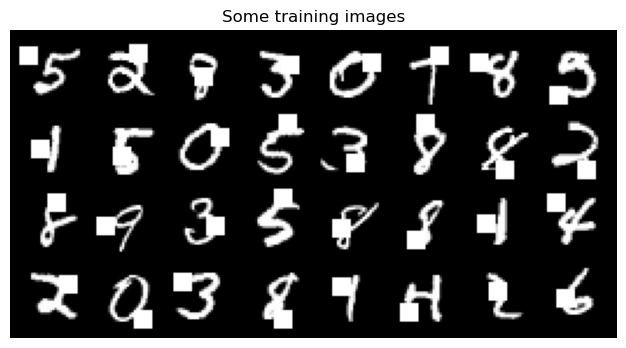

In [28]:
items = next(iter(train_dataloader))
items = zero_out_image_portion(items[0], 8)
plt.figure(figsize=(8,4))
plt.axis("off")
plt.title("Some training images")
plt.imshow(np.transpose(vutils.make_grid(items.to(device)[:32], padding=4, normalize=True).cpu(),(1,2,0)))

In [30]:
num_GPUs = 2 # change accordingly

model = VAE(latent_dim=16, in_channels=1).to(device)
if (device.type == 'cuda') and (num_GPUs > 1):
    model = nn.DataParallel(model, list(range(num_GPUs)))
    print(f'Using {num_GPUs} GPUs')

Using 2 GPUs


In [31]:
max_epochs = 20
lr = 1e-3
reconst_loss = F.binary_cross_entropy#(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=lr)

In [32]:
losses = []

zeros_window = 8

for epoch in range(max_epochs):
    for i, data in enumerate(train_dataloader):
        model.zero_grad()
        x_clean = data[0].to(device)
        
        x_zeroed = zero_out_image_portion(x_clean, zeros_window)
        out = model(x_zeroed)
        
        loss = reconst_loss(out, x_clean, reduction='sum')
        
        if i % 200 == 0:
            print(f'[{epoch}/{max_epochs-1}][{i}/{len(train_dataloader)}]|\t Loss:{loss.item()}')
            losses.append(loss.item())
        loss.backward()
        optimizer.step()

[0/19][0/938]|	 Loss:40434.49609375
[0/19][200/938]|	 Loss:23292.40625
[0/19][400/938]|	 Loss:19663.703125
[0/19][600/938]|	 Loss:16887.70703125
[0/19][800/938]|	 Loss:15167.1513671875
[1/19][0/938]|	 Loss:13929.0205078125
[1/19][200/938]|	 Loss:12193.279296875
[1/19][400/938]|	 Loss:11503.35546875
[1/19][600/938]|	 Loss:10279.091796875
[1/19][800/938]|	 Loss:9898.357421875
[2/19][0/938]|	 Loss:9763.7705078125
[2/19][200/938]|	 Loss:8603.9453125
[2/19][400/938]|	 Loss:8637.4033203125
[2/19][600/938]|	 Loss:8180.54052734375
[2/19][800/938]|	 Loss:7453.11572265625
[3/19][0/938]|	 Loss:8034.021484375
[3/19][200/938]|	 Loss:7381.29443359375
[3/19][400/938]|	 Loss:7031.884765625
[3/19][600/938]|	 Loss:6552.69189453125
[3/19][800/938]|	 Loss:6503.69970703125
[4/19][0/938]|	 Loss:6629.96337890625
[4/19][200/938]|	 Loss:6297.89013671875
[4/19][400/938]|	 Loss:6083.45654296875
[4/19][600/938]|	 Loss:6379.369140625
[4/19][800/938]|	 Loss:6094.52685546875
[5/19][0/938]|	 Loss:5681.162109375
[5/19

Text(0.5, 1.0, 'Loss (binary CE)')

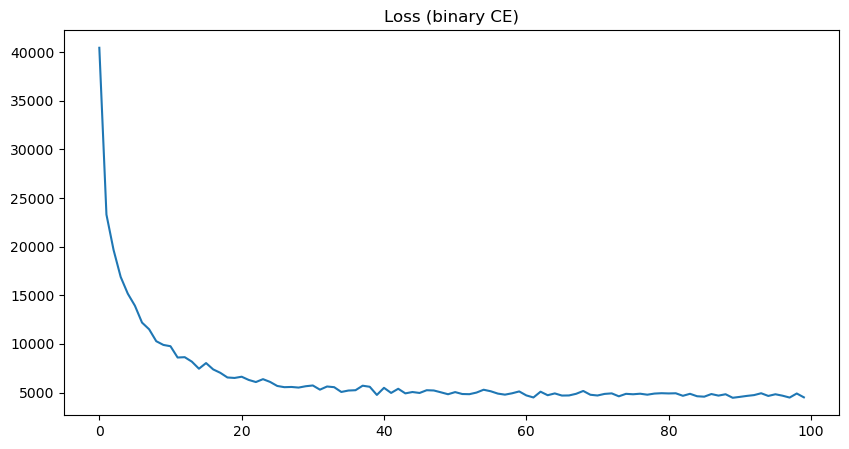

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(losses)
ax.set_title('Loss (binary CE)')
fig.show()

### Example of Input-Output

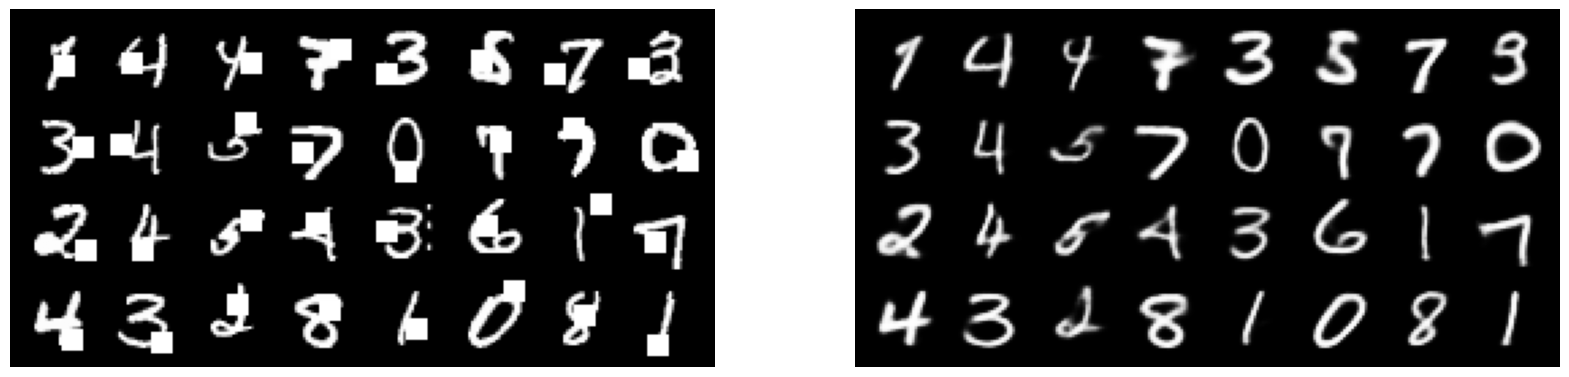

In [71]:
with torch.no_grad():
    batch = next(iter(train_dataloader))[0]
    batch_zero = zero_out_image_portion(batch, zeros_window)
    batch_out = model(batch_zero)
    
    fig, ax = plt.subplots(1,2, figsize=(20, 7))
    ax[0].imshow(np.transpose(vutils.make_grid(batch_zero.to(device)[:32], padding=4, normalize=True).cpu(),(1,2,0)))
    ax[1].imshow(np.transpose(vutils.make_grid(batch_out.to(device)[:32], padding=4, normalize=True).cpu(),(1,2,0)))
    ax[0].axis("off")
    ax[1].axis("off")
    fig.show()

### Stress test: increased window size 

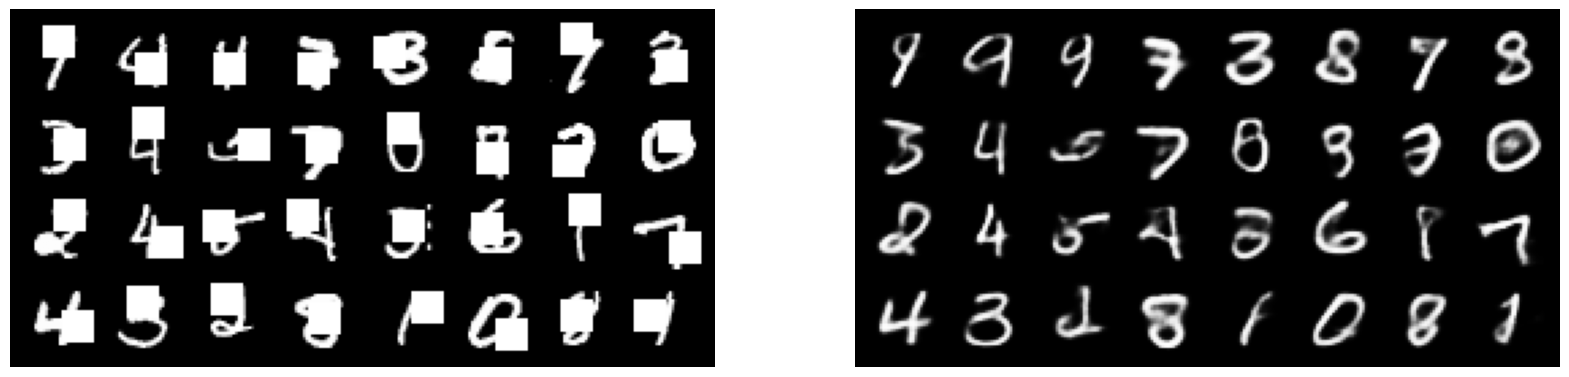

In [70]:
with torch.no_grad():
    batch = next(iter(train_dataloader))[0]
    batch_zero = zero_out_image_portion(batch, zeros_window+4)
    batch_out = model(batch_zero)
    
    fig, ax = plt.subplots(1,2, figsize=(20, 7))
    
    ax[0].imshow(np.transpose(vutils.make_grid(batch_zero.to(device)[:32], padding=4, normalize=True).cpu(),(1,2,0)))
    ax[1].imshow(np.transpose(vutils.make_grid(batch_out.to(device)[:32], padding=4, normalize=True).cpu(),(1,2,0)))
    ax[0].axis("off")
    ax[1].axis("off")
    fig.show()